In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

from utils.helpers import *
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
%load_ext autoreload
%autoreload 2

In [2]:
# Especifica las columnas que deseas cargar
columns_to_load = ['transaction_date', 'transaction_amount', 'transaction_type', 'fraction_flag']

# Lectura de los datos
data = pd.read_parquet(
    path='../../data/processed/data_processed.parquet',
    columns=columns_to_load  # Excluye la columna 'id'
)
data.sample(5, random_state=777)

,transaction_date,transaction_amount,transaction_type,fraction_flag
312003,2021-01-04 21:29:44,5.94,DEBITO,FRACCIONADA
3244910,2021-05-08 09:29:44,309.11,DEBITO,NO_FRACCIONADA
3234617,2021-02-04 11:12:48,8.32,DEBITO,NO_FRACCIONADA
158815,2021-03-01 17:51:29,17.83,DEBITO,NO_FRACCIONADA
1024802,2021-06-29 14:40:10,356.67,DEBITO,NO_FRACCIONADA


In [3]:
# Dimensiones del dataset
print(f'Número de muestras: {data.shape[0]}')
print(f'Predictores: {data.shape[1]}\n')
data.info()

Número de muestras: 4303384
Predictores: 4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4303384 entries, 0 to 4303383
Data columns (total 4 columns):
 #   Column              Dtype         
---  ------              -----         
 0   transaction_date    datetime64[ns]
 1   transaction_amount  float64       
 2   transaction_type    object        
 3   fraction_flag       object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 131.3+ MB


In [4]:
# Función para capturar los tipos de variables
continuous, categoricals, discretes, temporaries = capture_variables(data=data.loc[:, data.columns != 'fraction_flag']) # type: ignore

		Tipos de variables
Hay 1 variables continuas
Hay 0 variables discretas
Hay 1 variables temporales
Hay 1 variables categóricas


In [5]:
# Resumen estadístico de variables continuas
data[continuous].describe().T

,count,mean,std,min,25%,50%,75%,max
transaction_amount,"4,303,384.00",191.34,241.53,5.94,35.67,107.00,237.78,"3,210.01"


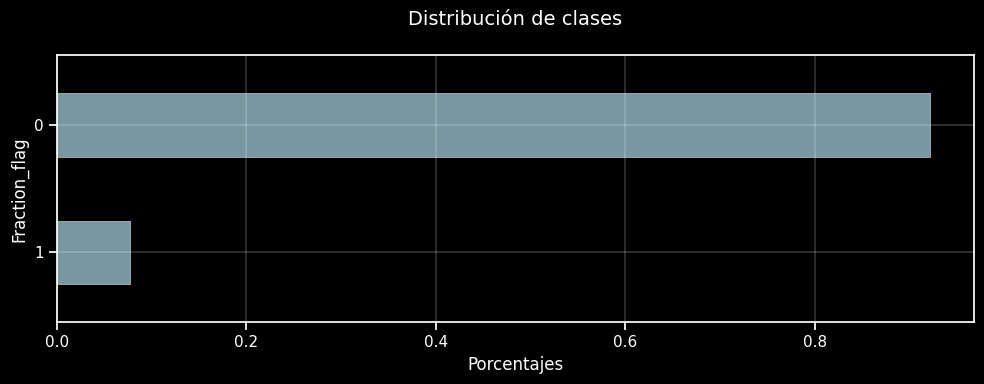

In [6]:
# Distribución de clases
class_distribution(
    data=data, 
    target='fraction_flag'
)

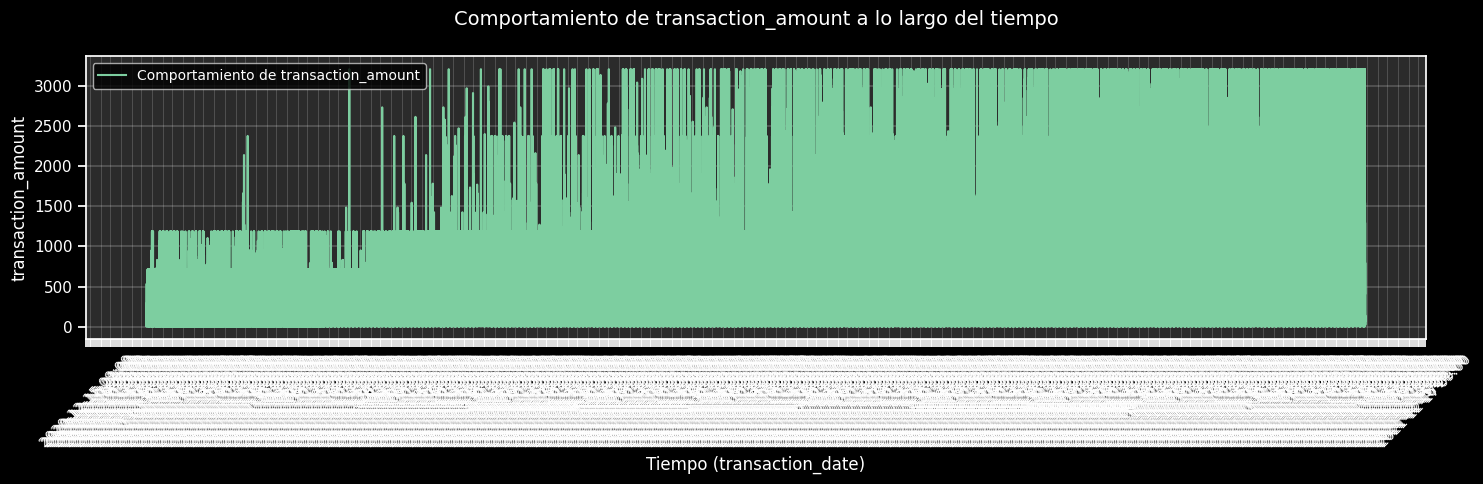

In [7]:
# Graficar las variables temporales
plot_variable_behaviors_over_time(
    data=data.loc[:, data.columns != 'transaction_type'],
    time_col='transaction_date', 
    target_col='fraction_flag'
)

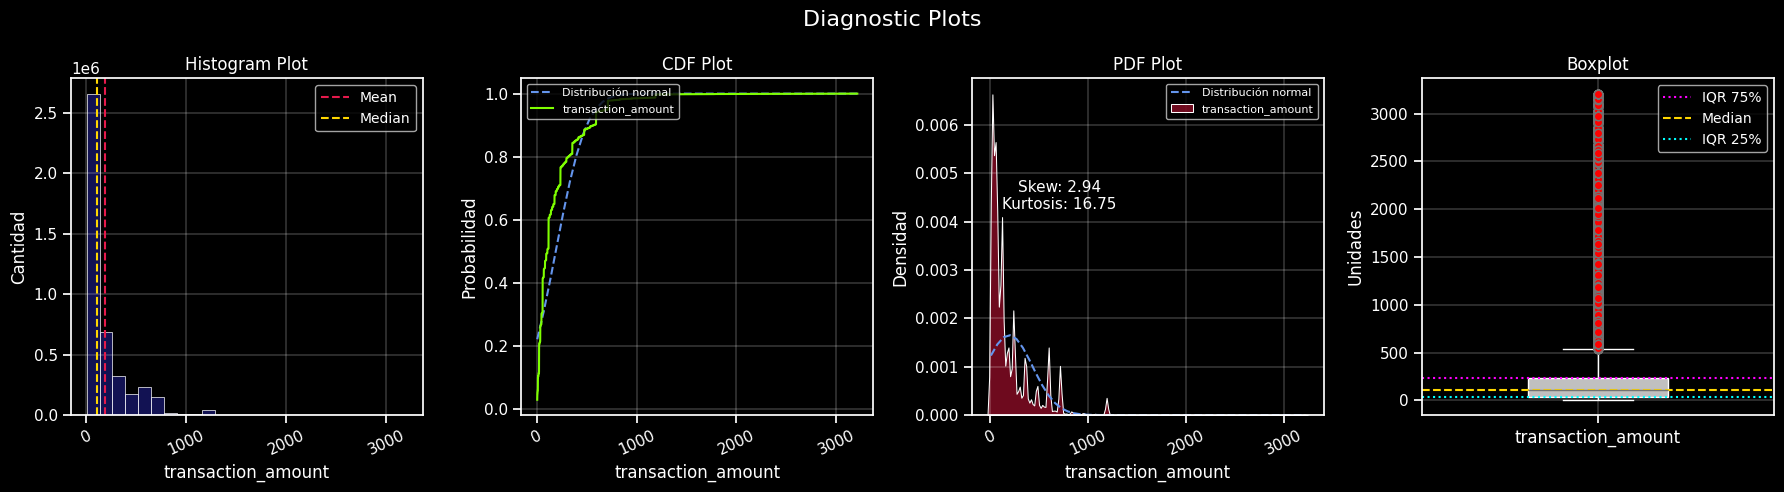

In [8]:
# Función para observar el comportamiento de variables continuas
diagnostic_plots(
    data=data.loc[:, data.columns != 'fraction_flag'],
    variables=continuous
)

<IPython.core.display.Latex object>

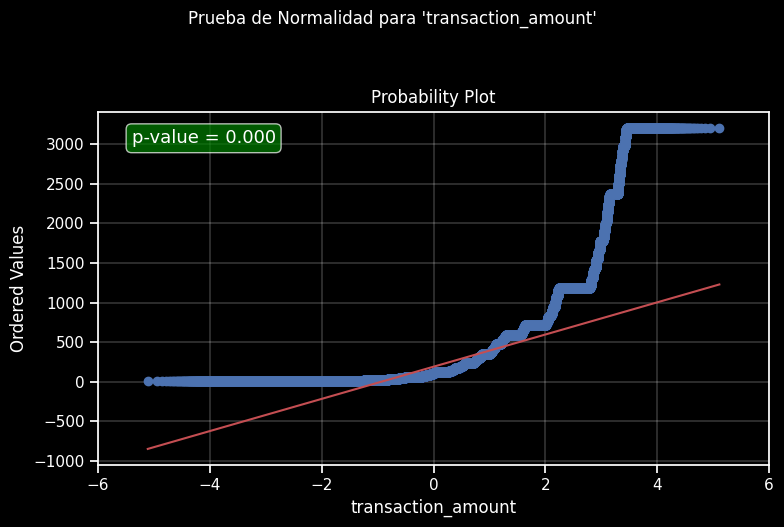

In [9]:
# Función para observar el comportamiento de variables continuas
single_normality_test(
    data=data,
    variable=continuous[0]
)

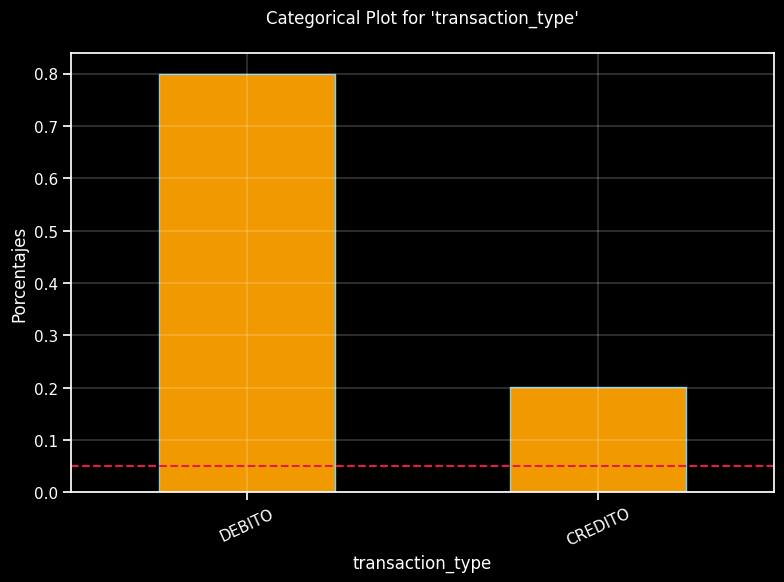

In [10]:
# Función para observar el comportamiento de variables categóricas
single_categorical_plot(
    data=data.loc[:, data.columns != 'fraction_flag'], 
    variable=categoricals[0]
)

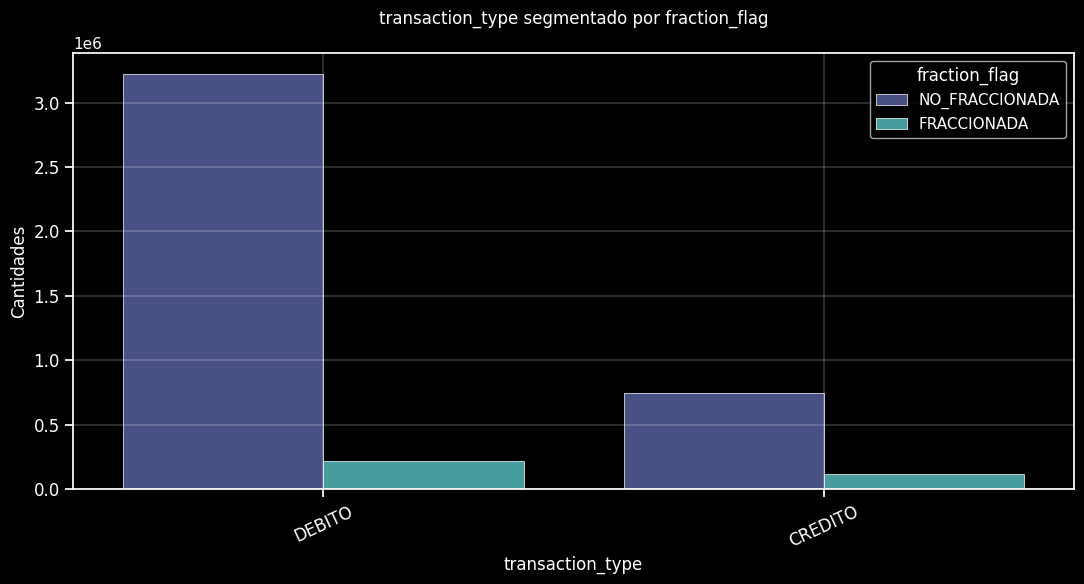

In [11]:
# Función para graficar las categóricas segmentadas por el target
categoricals_hue_target(
    data=data,
    variables=categoricals,
    target='fraction_flag'
)